In [1]:
import os
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import re
import openpyxl

BASE_PATH = 'D:/Data/KIMoDIs/global-groundwater-models-main'
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODEL_PATH = os.path.join(BASE_PATH, 'models')
RESULT_PATH = os.path.join(BASE_PATH, 'results')

LAG = 52  # weeks
LEAD = 12  # weeks

# Roughly 80/10/10
TRAIN_PERIOD = (pd.Timestamp(1990, 1, 1), pd.Timestamp(2010, 1, 1))
VAL_PERIOD = (pd.Timestamp(2010, 1, 1), pd.Timestamp(2013, 1, 1))
TEST_PERIOD = (pd.Timestamp(2013, 1, 1), pd.Timestamp(2016, 1, 1))

TIME_IDX = pd.date_range(TRAIN_PERIOD[0], TEST_PERIOD[1], freq='W-SUN', inclusive='neither', name='time').to_frame().reset_index(drop=True)
TIME_IDX.index.name = 'time_idx'
TIME_IDX = TIME_IDX.reset_index()

In [2]:
FONT_SIZE = 20
# Plotting settings
plt.rcParams.update({
        "font.size": FONT_SIZE,
        "xtick.labelsize": FONT_SIZE-2,
        "ytick.labelsize": FONT_SIZE-2,
        
        'axes.titleweight': 'bold',
        'axes.labelweight': 'bold',
        
        'lines.markersize': 3,
        
        "legend.frameon": True,
        "legend.fontsize": FONT_SIZE-2,
        "legend.title_fontsize": FONT_SIZE-2,
        
        "savefig.dpi": 300,     # higher resolution output.
        "savefig.bbox": 'tight'})

In [3]:
train_df = pq.read_table(os.path.join(DATA_PATH, 'train_df.parquet'))
val_df = pq.read_table(os.path.join(DATA_PATH, 'val_df.parquet'))
test_df = pq.read_table(os.path.join(DATA_PATH, 'test_df.parquet'))

train_df = train_df.to_pandas()
val_df = val_df.to_pandas()
test_df = test_df.to_pandas()

In [4]:
# Set training, validation and test data to common ids
id_test = test_df['proj_id'].unique()

train_df = train_df[train_df['proj_id'].isin(id_test)]
val_df = val_df[val_df['proj_id'].isin(id_test)]

In [5]:
# IDs per fedaral state
id_per_fd = pd.DataFrame(train_df['proj_id'].astype(str).unique(), columns=['proj_id'])
id_per_fd['fs_abbrev'] = id_per_fd['proj_id'].str.extract(r'^(\w{2})')

id_per_fd = pd.DataFrame(id_per_fd.groupby('fs_abbrev')['fs_abbrev'].value_counts()).reset_index()
id_per_fd.to_csv('J:/B22-FISHy/NUTZER/Kunz.S/global_mod_paper/results/fs_count.csv', index=False)

### Time series statistics

In [6]:
# Variance & SD in time series
# Add Skewness?
# train_df.groupby('proj_id')['gwl'].agg('var').describe()
train_df.groupby('proj_id')['gwl'].agg(['std']).describe()

std_gwl = pd.DataFrame(train_df.groupby('proj_id')['gwl'].agg('std')).reset_index()
std_gwl.rename(columns={'gwl':'std_gwl'}, inplace=True)

In [7]:
std_gwl.describe()
# std_gwl[std_gwl['std_gwl']>20]

,std_gwl
count,5308.000000
mean,0.523899
std,0.916105
min,0.032672
25%,0.224140
50%,0.334898
75%,0.507408
max,21.580503


### Plotting time series length of each GWM on Germany map

In [9]:
# Overview over the length of gwl time series
# Median length in the training data
ts_counts = pd.DataFrame(train_df['proj_id'].value_counts()).reset_index()

In [10]:
ts_counts.describe()

,count
count,5308.000000
mean,856.201017
std,243.714497
min,309.000000
25%,655.000000
50%,1043.000000
75%,1043.000000
max,1043.000000


In [11]:
# Transform to years
ts_counts['years'] = ts_counts['count'] / 52.1775
ts_counts['years'] = round(ts_counts['years'], 0)

In [15]:
pd.DataFrame(ts_counts['years'].describe()).to_excel('J:/B22-FISHy/NUTZER/Kunz.S/global_mod_paper/results/ts_length_statistics.xlsx')

Text(0.5, 0, 'Lengths of groundwater level time series (weeks)')

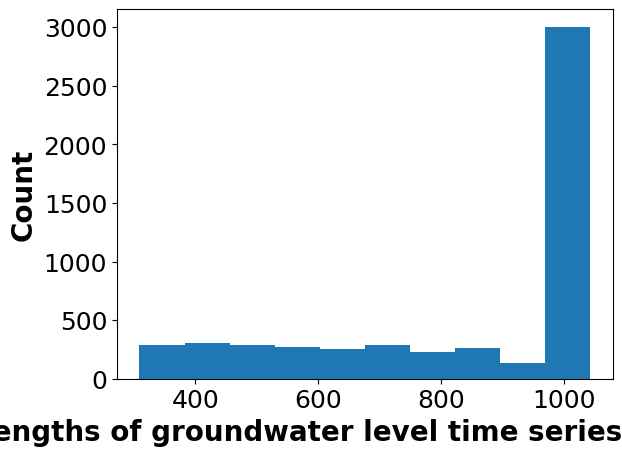

In [11]:
# Simple bar plot
plt.hist(ts_counts['count'], density=False)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Lengths of groundwater level time series (weeks)')

# 54 % of time series cover the whole training period until 1990
# len(ts_counts[ts_counts['count']==1043])/len(ts_counts)

In [12]:
coord_df = train_df[['lon', 'lat', 'proj_id']].drop_duplicates(subset=['proj_id'])
gdf = gpd.GeoDataFrame(coord_df, geometry=gpd.points_from_xy(coord_df['lon'], coord_df['lat']), crs='EPSG:4326')
gdf = pd.merge(gdf, ts_counts, on='proj_id')
gdf

,lon,lat,proj_id,geometry,count,years
0,13.643609,53.416804,BB_25470023,POINT (13.64361 53.41680),476,9.0
1,13.643653,53.416793,BB_25470024,POINT (13.64365 53.41679),476,9.0
2,13.826532,53.452024,BB_25480025,POINT (13.82653 53.45202),476,9.0
3,13.677407,53.457078,BB_25480026,POINT (13.67741 53.45708),476,9.0
4,14.144721,53.422495,BB_25500006,POINT (14.14472 53.42250),1043,20.0
...,...,...,...,...,...,...
5303,12.182819,51.095535,ST_49390127,POINT (12.18282 51.09554),519,10.0
5304,12.182236,51.095587,ST_49397128,POINT (12.18224 51.09559),519,10.0
5305,12.182970,51.096485,ST_49397327,POINT (12.18297 51.09648),519,10.0
5306,12.182236,51.095587,ST_49399128,POINT (12.18224 51.09559),519,10.0


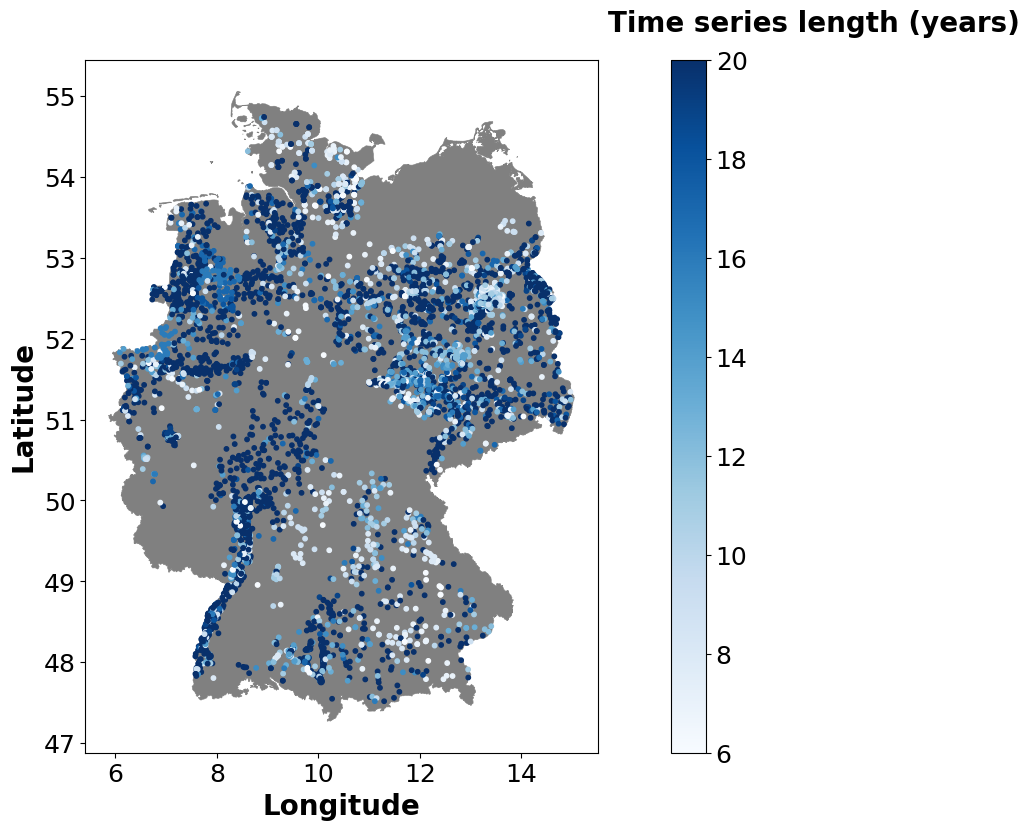

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(19, 9))

germany_shp_df = gpd.read_file(os.path.join(DATA_PATH, 'Germany.shp'))
germany_shp_df.plot(ax=ax, color='grey', alpha=1., edgecolor="face", linewidth=0.4, aspect=1.5)

# Plot points from GeoDataFrame gdf with color based on the 'count' column
gdf.plot(ax=ax, marker='o', markersize=10, alpha=1., column='years', legend=True, cmap='Blues')

# Add axis labels
ax.set_xlabel('Longitude', fontweight='bold')
ax.set_ylabel('Latitude', fontweight='bold')

# Add a legend caption
ax.text(15.7, 55.8, 'Time series length (years)', fontweight='bold')

# Show the plot
plt.show()

fig.savefig(os.path.join(BASE_PATH, 
                         'plots_global_gwm', 
                         'plots',
                         'ts_lengths_on_map_plot.png'),
           bbox_inches='tight')

fig.savefig('J:/B22-FISHy/NUTZER/Kunz.S/global_mod_paper/figures/ts_lengths_on_map_plot.png', bbox_inches='tight')
fig.savefig('J:/B22-FISHy/NUTZER/Kunz.S/global_mod_paper/figures/ts_lengths_on_map_plot.svg', bbox_inches='tight')

### Correlation matrix plot

In [ ]:
_col_exclude = ['precip', 'humid', 'temp', 'sin_temp', 'lai', 'day_sin', 'day_cos', 'gwl', 'time', 'time_idx', 'lon', 'lat', 'hyraum_gr', 'aquifer_type', 'permeability_coef', 'soil_texture', 'land_cover'] 
col_stat_num = [item for item in list(train_df) if item not in _col_exclude]

train_static_num = train_df[col_stat_num].drop_duplicates(subset=['proj_id'])
corr_static = train_static_num.drop(['proj_id'], axis=1).corr()

In [ ]:
# Correlation matrix plot
mask = np.zeros_like(corr_static, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# TODO: make names vertical on x axis
corr_static[mask] = np.nan
(corr_static
 .style
 .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

In [ ]:
# Create the correlation plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_static, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"fontsize": 7})

# Rotate the x-axis labels vertically
plt.xticks(rotation='vertical')

# Adjust the font size of the correlation values
# plt.tick_params(axis='both', which='both', labelsize=8)
plt.tight_layout()
# plt.show()

plt.savefig(os.path.join(BASE_PATH, 
                        'notebooks', 
                        'preprocessing',
                        'plots_global_gwm',
                        'plots',
                        'correlation_plot.png'))

### Spatial distribution

In [73]:
# Nr. of wells per federal state
proj_ids = train_df['proj_id'].unique()

# Abbreviation federal states in Germany
fs_list = ['BW', 'BY', 'BE', 'BB', 'HB', 'HH', 'HE', 'MV', 'NI', 'NW', 'RP', 'SL', 'SN', 'ST', 'SH', 'TH']

n_sites_per_fs = {}

for fs in fs_list:
    n_sites_per_fs[fs] = len([x for x in proj_ids if re.match(f'{fs}_*', x)])
    
n_sites_per_fs = pd.DataFrame.from_dict(n_sites_per_fs, orient='index').reset_index()
n_sites_per_fs = n_sites_per_fs.rename({'index':'Federal state', 0:'Nr. of wells'}, axis=1)

# J:\B22-FISHy\NUTZER\Kunz.S\global_mod_paper\si
n_sites_per_fs.to_excel('J:/B22-FISHy/NUTZER/Kunz.S/global_mod_paper/si/n_sites_per_fs.xlsx')